In [1]:
import pandas as pd
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt 
import sys
sys.path.append("..") # src exists in the parent directory
import src.config
output_name = "LastFourQuartersOrBestEstimate_On_DissolvedSmallerCitiesHexes.gpkg"
output_dir = src.config.DATA_DIRECTORY / "processed" / "statistical_geometries"

In [2]:
def convert_kbps_to_mbps(table, copy=False):
    if copy:
        table = table.copy()
    for col in table.columns:
        if "kbps" not in col:
            continue
        table.loc[:, col] /= 1000
        table.rename(columns={col: col.replace("kbps", "Mbps")}, inplace=True)
    return table

In [76]:
def load_speed_data():
    print("Loading speed data...")

    speed_data = gp.read_file(output_dir / output_name, driver="GPKG")

    speed_data["Ookla_Pop_at_50_10"] = (
        speed_data["Pop2016"] * speed_data["ookla_50_10_percentile"] / 100
    )

    speed_data = convert_kbps_to_mbps(speed_data)

    speed_data["is_rural"] = ~speed_data.PCCLASS.isin(["2", "3", "4"])

    # speed_data["PRUID"] = speed_data["PRCODE"].replace(PRCODE_MAP)
    speed_data["PCCLASS"] = speed_data["PCCLASS"].fillna("")
    return speed_data

In [4]:
data = load_speed_data()

Loading speed data...


In [99]:
data

,PCPUID,HEXUID_PCPUID,PRCODE,PCNAME,PCCLASS,Pop2016,TDwell2016_TLog2016,URDwell2016_RH2016,PHH_Count,Common_Type,...,num_tiles,Down_50_percentile,Up_10_percentile,ookla_50_10_percentile,min_year,max_year,connections,geometry,Ookla_Pop_at_50_10,is_rural
0,100792,NL47580528-100792,NL,St. John's,4,9896.147562,5058.332094,4318.056742,685.0,3.0,...,269.0,91.078067,96.282528,91.078067,Q4 2021,Q4 2022,fixed,"MULTIPOLYGON (((-52.78788 47.56551, -52.78288 ...",9013.219898,False
1,100792,NL47580529-100792,NL,St. John's,4,4252.819048,1648.265873,1558.259524,437.0,4.0,...,214.0,92.523364,96.728972,92.523364,Q4 2021,Q4 2022,fixed,"POLYGON ((-52.90996 47.56425, -52.90990 47.564...",3934.851268,False
2,100792,NL47430528-100792,NL,St. John's,4,2662.527342,1056.284918,1025.692964,149.0,3.0,...,5.0,100.000000,100.000000,100.000000,Q4 2021,Q4 2022,fixed,"POLYGON ((-52.76428 47.45587, -52.76436 47.454...",2662.527342,False
3,100792,NL47510528-100792,NL,St. John's,4,24029.650382,10449.110393,9692.839561,1684.0,3.0,...,424.0,94.811321,98.584906,94.811321,Q4 2021,Q4 2022,fixed,"POLYGON ((-52.79738 47.49030, -52.79781 47.490...",22782.828900,False
4,100792,NL47510529-100792,NL,St. John's,4,9484.733870,3792.755213,3563.152336,909.0,4.0,...,319.0,94.984326,98.432602,94.984326,Q4 2021,Q4 2022,fixed,"POLYGON ((-52.91007 47.51346, -52.91014 47.513...",9009.010541,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61175,NaN,BC55061204,BC,NaN,,0.000000,0.000000,0.000000,NaN,NaN,...,1.0,0.000000,0.000000,0.000000,Q3 2021,Q3 2021,mobile,"POLYGON ((-120.35743 55.05748, -120.37753 55.0...",0.000000,True
61176,NaN,BC55711204,BC,NaN,,31.214286,12.814286,12.266667,12.0,5.0,...,6.0,0.000000,66.666667,0.000000,Q1 2021,Q2 2022,fixed,"POLYGON ((-120.35743 55.70785, -120.37753 55.6...",0.000000,True
61177,NaN,BC55831204,BC,NaN,,96.002305,38.937423,37.977094,93.0,4.0,...,15.0,26.666667,40.000000,26.666667,Q4 2021,Q4 2022,fixed,"POLYGON ((-120.35743 55.82726, -120.37753 55.7...",25.600615,True
61178,NaN,BC56311204,BC,NaN,,31.666246,13.291211,12.952932,52.0,4.0,...,2.0,50.000000,50.000000,50.000000,Q2 2019,Q2 2021,fixed,"POLYGON ((-120.35743 56.30863, -120.37753 56.2...",15.833123,True


/tmp/ipykernel_70612/232682628.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


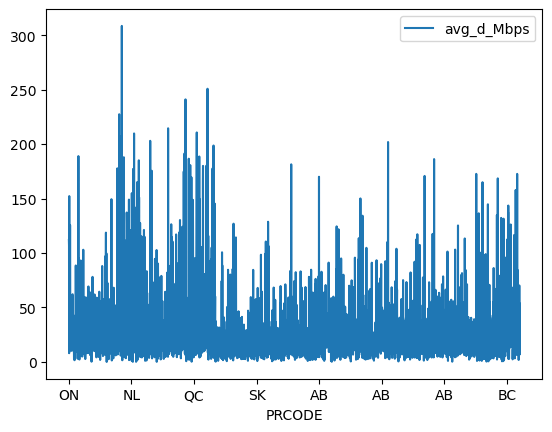

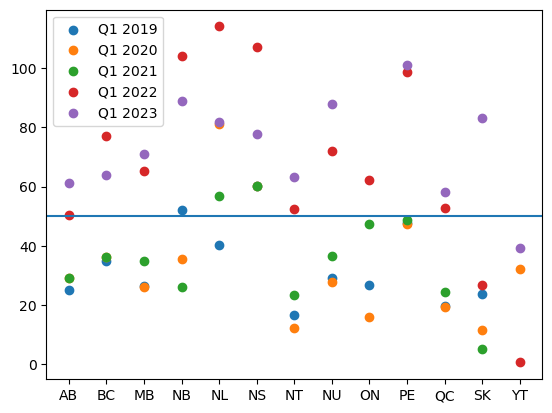

In [77]:
data[data['min_year'] == "Q1 2019"].plot.line(x="PRCODE", y="avg_d_Mbps")
labels = data['PRCODE'].sort_values().unique()
fig = plt.subplots()
ax = plt.gca()
ax.set_xticklabels(labels)
# fig = plt.figure(figsize=(100, 100), dpi=80)
for year in ["2019","2020","2021","2022","2023"]:
    for quarter in ["Q1"]:
        plot_data = data[data['min_year'] == str(quarter + ' ' + year)]
        plot_data1 = plot_data[['PRCODE','avg_d_Mbps']].groupby(['PRCODE']).mean()
        # print(plot_data1)
        plt.scatter(plot_data1.index.tolist(), plot_data1['avg_d_Mbps'], label = str(quarter + ' ' + year))
plt.axhline(y=50)        
plt.legend()
plt.show()

In [ ]:
x = time y = spped points = provinces

Index(['No Data', 'Q1 2019', 'Q1 2020', 'Q1 2021', 'Q1 2022', 'Q1 2023',
       'Q2 2019', 'Q2 2020', 'Q2 2021', 'Q2 2022', 'Q3 2019', 'Q3 2020',
       'Q3 2021', 'Q3 2022', 'Q4 2019', 'Q4 2020', 'Q4 2021', 'Q4 2022'],
      dtype='object', name='min_year')
Index(['No Data', 'Q1 2019', 'Q1 2020', 'Q1 2021', 'Q1 2022', 'Q1 2023',
       'Q2 2019', 'Q2 2020', 'Q2 2021', 'Q2 2022', 'Q3 2019', 'Q3 2020',
       'Q3 2021', 'Q3 2022', 'Q4 2019', 'Q4 2020', 'Q4 2021', 'Q4 2022'],
      dtype='object', name='min_year')
Index(['No Data', 'Q1 2019', 'Q1 2020', 'Q1 2021', 'Q1 2022', 'Q1 2023',
       'Q2 2019', 'Q2 2020', 'Q2 2021', 'Q2 2022', 'Q3 2019', 'Q3 2020',
       'Q3 2021', 'Q3 2022', 'Q4 2019', 'Q4 2020', 'Q4 2021', 'Q4 2022'],
      dtype='object', name='min_year')
Index(['No Data', 'Q1 2019', 'Q1 2020', 'Q1 2021', 'Q1 2022', 'Q1 2023',
       'Q2 2019', 'Q2 2020', 'Q2 2021', 'Q2 2022', 'Q3 2019', 'Q3 2020',
       'Q3 2021', 'Q3 2022', 'Q4 2019', 'Q4 2020', 'Q4 2021', 'Q4 2022'],
   

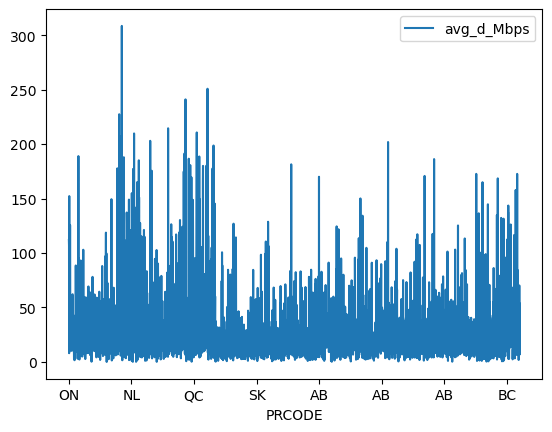

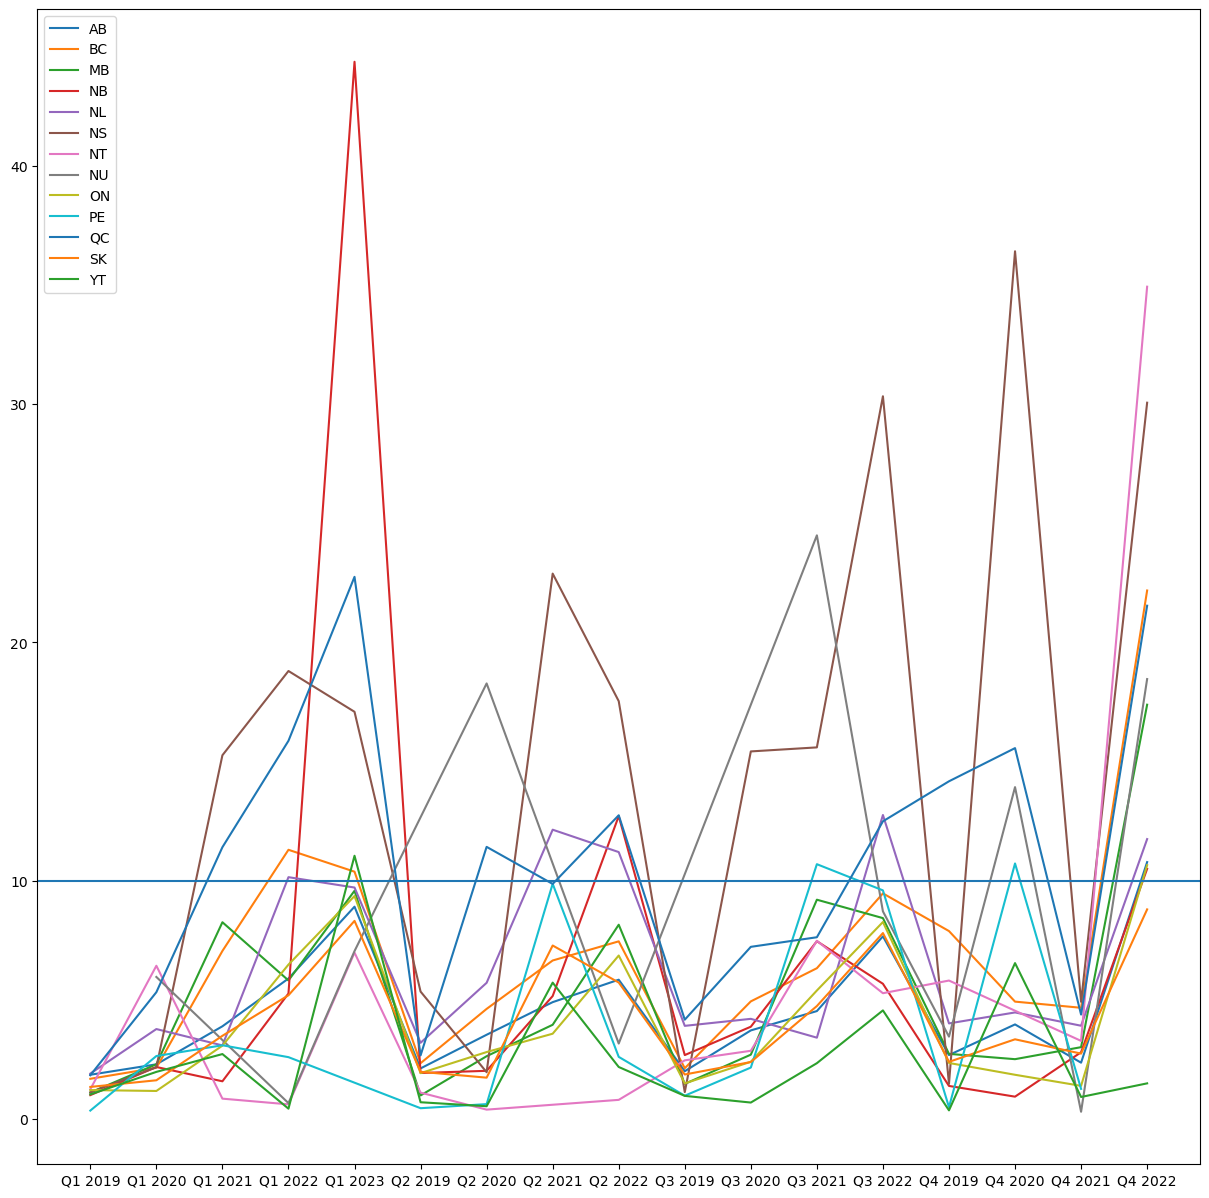

In [95]:
data[data['min_year'] == "Q1 2019"].plot.line(x="PRCODE", y="avg_d_Mbps")
labels = data['PRCODE'].sort_values().unique()
fig2 = plt.subplots(figsize=(15, 15))
# fig = plt.figure(figsize=(100, 100), dpi=80)
# for year in ["2019","2020","2021","2022","2023"]:
#     for quarter in ["Q1","Q2","Q3","Q4"]:
#         plot_data = data[data['min_year'] == str(quarter + ' ' + year)]
#         plot_data1 = plot_data[['PRCODE','avg_d_Mbps']].groupby(['PRCODE']).mean()
#         # print(plot_data1)
#         plt.scatter(plot_data1.index.tolist(), plot_data1['avg_d_Mbps'], label = str(quarter + ' ' + year))

for province in labels:
    plot_data = data[data['PRCODE'] == province]
    plot_data = plot_data[plot_data[]]
    plot_data1 = plot_data[['min_year', 'min_u_Mbps']].groupby(['min_year']).mean()
    print(plot_data1.index)
    plt.plot(plot_data1.index.tolist(), plot_data1['min_u_Mbps'], label = province)
plt.axhline(y=10)        
plt.legend()
plt.show()